# TAT-C Interface Implementation

Specifies a function with well-defined input (`CoverageRequest`) and output (`CoverageResponse`) using TAT-C's implementation.

In [11]:
from datetime import timedelta
from joblib import Parallel, delayed
from scipy.stats import hmean
import geopandas as gpd
import pandas as pd

from tatc.schemas import Instrument, Satellite as TATC_Satellite, TwoLineElements, Point
from tatc.analysis import (
    collect_multi_observations,
    aggregate_observations,
    reduce_observations,
)

from eose.coverage import (
    CoverageSample,
    CoverageRecord,
    CoverageRequest,
    CoverageResponse,
)
from eose.observation import (
    ObservationSample,
    ObservationRecord,
    ObservationRequest,
    ObservationResponse,
)
from eose.grids import UniformAngularGrid
from eose.orbits import GeneralPerturbationsOrbitState
from eose.satellites import Satellite


def observation_tatc(request: ObservationRequest) -> ObservationResponse:
    has_unique_ids = len(set(target.id for target in request.targets)) == len(
        request.targets
    )
    point_ids = [
        target.id if has_unique_ids and isinstance(target.id, int) else i
        for i, target in enumerate(request.targets)
    ]
    satellites = [
        TATC_Satellite(
            name=satellite.orbit.object_name,
            orbit=TwoLineElements(tle=satellite.orbit.to_tle()),
            instruments=[
                Instrument(name="Default", field_of_regard=satellite.field_of_view)
            ],
        )
        for satellite in request.satellites
    ]
    observations = pd.concat(
        Parallel(-1)(
            delayed(collect_multi_observations)(
                Point(
                    id=point_id,
                    longitude=request.targets[i].position[0],
                    latitude=request.targets[i].position[1],
                    altitude=(
                        request.targets[i].position[2]
                        if len(request.targets[i].position) > 2
                        else 0
                    ),
                ),
                satellites,
                request.start,
                request.start + request.duration,
            )
            for i, point_id in enumerate(point_ids)
        )
    )
    records = list(
        observations.apply(
            lambda r: ObservationRecord(
                target=request.targets[point_ids.index(r["point_id"])],
                samples=observations[observations.point_id == r["point_id"]].apply(
                    lambda s: ObservationSample(
                        start=s.start, duration=s.end - s.start, source=s.satellite
                    ),
                    axis=1,
                ),
            ),
            axis=1,
        )
    ) + [
        ObservationRecord(target=request.targets[i])
        for i, point_id in enumerate(point_ids)
        if not any(observations["point_id"] == point_id)
    ]
    records.sort(key=lambda r: r.target.id)
    return ObservationResponse(
        **request.model_dump(exclude="observations"),
        observations=records,
    )


def coverage_tatc(request: CoverageRequest) -> CoverageResponse:
    has_unique_ids = len(
        set(record.target.id for record in request.observations)
    ) == len(request.observations)
    point_ids = [
        record.target.id if has_unique_ids and isinstance(record.target.id, int) else i
        for i, record in enumerate(request.observations)
    ]
    aggregated_obs = aggregate_observations(
        gpd.GeoDataFrame(
            [
                {
                    "point_id": point_ids[i],
                    "geometry": record.target.as_geometry(),
                    "satellite": sample.source,
                    "instrument": sample.source,
                    "start": sample.start,
                    "end": sample.start + sample.duration,
                    "epoch": sample.start + sample.duration / 2,
                }
                for i, record in enumerate(request.observations)
                for sample in record.samples
            ]
        )
    )
    reduced_obs = reduce_observations(aggregated_obs)
    return CoverageResponse(
        **request.model_dump(
            exclude=["observations", "harmonic_mean_revisit", "coverage_fraction"]
        ),
        observations=list(
            reduced_obs.apply(
                lambda r: CoverageRecord(
                    **request.observations[point_ids.index(r["point_id"])].model_dump(
                        exclude=["samples", "mean_revisit", "number_samples"]
                    ),
                    samples=aggregated_obs[
                        aggregated_obs.point_id == r["point_id"]
                    ].apply(
                        lambda s: CoverageSample(
                            start=s.start,
                            duration=s.end - s.start,
                            source=s.satellite,
                            revisit=None if pd.isna(s.revisit) else s.revisit,
                        ),
                        axis=1,
                    ),
                    mean_revisit=(
                        None
                        if pd.isna(r["revisit"])
                        else timedelta(seconds=r["revisit"].total_seconds())
                    ),
                    number_samples=r["samples"],
                ),
                axis=1,
            )
        )
        + [
            CoverageRecord(target=request.observations[i].target)
            for i, point_id in enumerate(point_ids)
            if not any(reduced_obs["point_id"] == point_id)
        ],
        harmonic_mean_revisit=(
            None
            if reduced_obs.dropna(subset="revisit").empty
            else timedelta(
                seconds=hmean(
                    reduced_obs.dropna(subset="revisit")["revisit"].dt.total_seconds()
                )
            )
        ),
        coverage_fraction=len(reduced_obs.index) / len(point_ids),
    )

# Example

Pulls OMM file from Celestrak, issues propagation request starting Jan 1 2024 for 7 days), and displays results.

In [12]:
import json
from datetime import datetime, timedelta, timezone

# note: celestrak request is rate-limited; using hard-coded version
# import requests
# response = requests.get("https://celestrak.org/NORAD/elements/gp.php?NAME=ZARYA&FORMAT=JSON").content
response = '[{"OBJECT_NAME":"ISS (ZARYA)","OBJECT_ID":"1998-067A","EPOCH":"2024-06-07T09:53:34.728000","MEAN_MOTION":15.50975122,"ECCENTRICITY":0.0005669,"INCLINATION":51.6419,"RA_OF_ASC_NODE":3.7199,"ARG_OF_PERICENTER":284.672,"MEAN_ANOMALY":139.0837,"EPHEMERIS_TYPE":0,"CLASSIFICATION_TYPE":"U","NORAD_CAT_ID":25544,"ELEMENT_SET_NO":999,"REV_AT_EPOCH":45703,"BSTAR":0.00033759,"MEAN_MOTION_DOT":0.00019541,"MEAN_MOTION_DDOT":0}]'
iss_omm = json.loads(response)[0]

In [13]:
from shapely.geometry import box, mapping

request = ObservationRequest(
    satellites=[
        Satellite(
            orbit=GeneralPerturbationsOrbitState.from_omm(iss_omm), field_of_view=100
        )
    ],
    targets=UniformAngularGrid(
        delta_latitude=20, delta_longitude=20, region=mapping(box(-180, -50, 180, 50))
    ).as_targets(),
    start=datetime(2024, 1, 1, tzinfo=timezone.utc),
    duration=timedelta(days=7),
)

display(request.model_dump_json())

response = observation_tatc(request)

display(response.model_dump_json())

data = response.as_dataframe()

display(data)

'{"start":"2024-01-01T00:00:00Z","duration":"P7D","targets":[{"id":36,"crs":null,"position":[-170.0,-40.0]},{"id":37,"crs":null,"position":[-150.0,-40.0]},{"id":38,"crs":null,"position":[-130.0,-40.0]},{"id":39,"crs":null,"position":[-110.0,-40.0]},{"id":40,"crs":null,"position":[-90.0,-40.0]},{"id":41,"crs":null,"position":[-70.0,-40.0]},{"id":42,"crs":null,"position":[-50.0,-40.0]},{"id":43,"crs":null,"position":[-30.0,-40.0]},{"id":44,"crs":null,"position":[-10.0,-40.0]},{"id":45,"crs":null,"position":[10.0,-40.0]},{"id":46,"crs":null,"position":[30.0,-40.0]},{"id":47,"crs":null,"position":[50.0,-40.0]},{"id":48,"crs":null,"position":[70.0,-40.0]},{"id":49,"crs":null,"position":[90.0,-40.0]},{"id":50,"crs":null,"position":[110.0,-40.0]},{"id":51,"crs":null,"position":[130.0,-40.0]},{"id":52,"crs":null,"position":[150.0,-40.0]},{"id":53,"crs":null,"position":[170.0,-40.0]},{"id":54,"crs":null,"position":[-170.0,-20.0]},{"id":55,"crs":null,"position":[-150.0,-20.0]},{"id":56,"crs":nul

'{"start":"2024-01-01T00:00:00Z","duration":"P7D","targets":[{"id":36,"crs":null,"position":[-170.0,-40.0]},{"id":37,"crs":null,"position":[-150.0,-40.0]},{"id":38,"crs":null,"position":[-130.0,-40.0]},{"id":39,"crs":null,"position":[-110.0,-40.0]},{"id":40,"crs":null,"position":[-90.0,-40.0]},{"id":41,"crs":null,"position":[-70.0,-40.0]},{"id":42,"crs":null,"position":[-50.0,-40.0]},{"id":43,"crs":null,"position":[-30.0,-40.0]},{"id":44,"crs":null,"position":[-10.0,-40.0]},{"id":45,"crs":null,"position":[10.0,-40.0]},{"id":46,"crs":null,"position":[30.0,-40.0]},{"id":47,"crs":null,"position":[50.0,-40.0]},{"id":48,"crs":null,"position":[70.0,-40.0]},{"id":49,"crs":null,"position":[90.0,-40.0]},{"id":50,"crs":null,"position":[110.0,-40.0]},{"id":51,"crs":null,"position":[130.0,-40.0]},{"id":52,"crs":null,"position":[150.0,-40.0]},{"id":53,"crs":null,"position":[170.0,-40.0]},{"id":54,"crs":null,"position":[-170.0,-20.0]},{"id":55,"crs":null,"position":[-150.0,-20.0]},{"id":56,"crs":nul

,geometry,target,samples
0,POINT (-170 -40),"{'id': 36, 'crs': None, 'position': [-170.0, -...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0..."
1,POINT (-170 -40),"{'id': 36, 'crs': None, 'position': [-170.0, -...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0..."
2,POINT (-170 -40),"{'id': 36, 'crs': None, 'position': [-170.0, -...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0..."
3,POINT (-170 -40),"{'id': 36, 'crs': None, 'position': [-170.0, -...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0..."
4,POINT (-170 -40),"{'id': 36, 'crs': None, 'position': [-170.0, -...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0..."
...,...,...,...
881,POINT (170 40),"{'id': 125, 'crs': None, 'position': [170.0, 4...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0..."
882,POINT (170 40),"{'id': 125, 'crs': None, 'position': [170.0, 4...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0..."
883,POINT (170 40),"{'id': 125, 'crs': None, 'position': [170.0, 4...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0..."
884,POINT (170 40),"{'id': 125, 'crs': None, 'position': [170.0, 4...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0..."


In [14]:
request2 = CoverageRequest(**response.model_dump())

display(request2.model_dump_json())

response2 = coverage_tatc(request2)

display(response2.model_dump_json())

data2 = response2.as_dataframe()

display(data2)

'{"start":"2024-01-01T00:00:00Z","duration":"P7D","targets":[{"id":36,"crs":null,"position":[-170.0,-40.0]},{"id":37,"crs":null,"position":[-150.0,-40.0]},{"id":38,"crs":null,"position":[-130.0,-40.0]},{"id":39,"crs":null,"position":[-110.0,-40.0]},{"id":40,"crs":null,"position":[-90.0,-40.0]},{"id":41,"crs":null,"position":[-70.0,-40.0]},{"id":42,"crs":null,"position":[-50.0,-40.0]},{"id":43,"crs":null,"position":[-30.0,-40.0]},{"id":44,"crs":null,"position":[-10.0,-40.0]},{"id":45,"crs":null,"position":[10.0,-40.0]},{"id":46,"crs":null,"position":[30.0,-40.0]},{"id":47,"crs":null,"position":[50.0,-40.0]},{"id":48,"crs":null,"position":[70.0,-40.0]},{"id":49,"crs":null,"position":[90.0,-40.0]},{"id":50,"crs":null,"position":[110.0,-40.0]},{"id":51,"crs":null,"position":[130.0,-40.0]},{"id":52,"crs":null,"position":[150.0,-40.0]},{"id":53,"crs":null,"position":[170.0,-40.0]},{"id":54,"crs":null,"position":[-170.0,-20.0]},{"id":55,"crs":null,"position":[-150.0,-20.0]},{"id":56,"crs":nul

'{"start":"2024-01-01T00:00:00Z","duration":"P7D","targets":[{"id":36,"crs":null,"position":[-170.0,-40.0]},{"id":37,"crs":null,"position":[-150.0,-40.0]},{"id":38,"crs":null,"position":[-130.0,-40.0]},{"id":39,"crs":null,"position":[-110.0,-40.0]},{"id":40,"crs":null,"position":[-90.0,-40.0]},{"id":41,"crs":null,"position":[-70.0,-40.0]},{"id":42,"crs":null,"position":[-50.0,-40.0]},{"id":43,"crs":null,"position":[-30.0,-40.0]},{"id":44,"crs":null,"position":[-10.0,-40.0]},{"id":45,"crs":null,"position":[10.0,-40.0]},{"id":46,"crs":null,"position":[30.0,-40.0]},{"id":47,"crs":null,"position":[50.0,-40.0]},{"id":48,"crs":null,"position":[70.0,-40.0]},{"id":49,"crs":null,"position":[90.0,-40.0]},{"id":50,"crs":null,"position":[110.0,-40.0]},{"id":51,"crs":null,"position":[130.0,-40.0]},{"id":52,"crs":null,"position":[150.0,-40.0]},{"id":53,"crs":null,"position":[170.0,-40.0]},{"id":54,"crs":null,"position":[-170.0,-20.0]},{"id":55,"crs":null,"position":[-150.0,-20.0]},{"id":56,"crs":nul

,geometry,target,samples,mean_revisit,number_samples
0,POINT (-170 -40),"{'id': 36, 'crs': None, 'position': [-170.0, -...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0...",0 days 12:37:01.727095,14
1,POINT (-170 -40),"{'id': 36, 'crs': None, 'position': [-170.0, -...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0...",0 days 12:37:01.727095,14
2,POINT (-170 -40),"{'id': 36, 'crs': None, 'position': [-170.0, -...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0...",0 days 12:37:01.727095,14
3,POINT (-170 -40),"{'id': 36, 'crs': None, 'position': [-170.0, -...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0...",0 days 12:37:01.727095,14
4,POINT (-170 -40),"{'id': 36, 'crs': None, 'position': [-170.0, -...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0...",0 days 12:37:01.727095,14
...,...,...,...,...,...
881,POINT (170 40),"{'id': 125, 'crs': None, 'position': [170.0, 4...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0...",0 days 11:52:19.407913,13
882,POINT (170 40),"{'id': 125, 'crs': None, 'position': [170.0, 4...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0...",0 days 11:52:19.407913,13
883,POINT (170 40),"{'id': 125, 'crs': None, 'position': [170.0, 4...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0...",0 days 11:52:19.407913,13
884,POINT (170 40),"{'id': 125, 'crs': None, 'position': [170.0, 4...","[{'source': 'ISS (ZARYA)', 'start': '2024-01-0...",0 days 11:52:19.407913,13


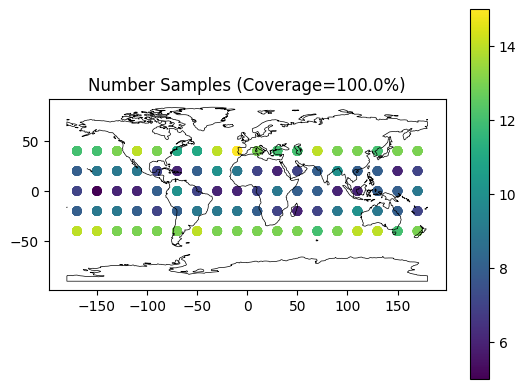

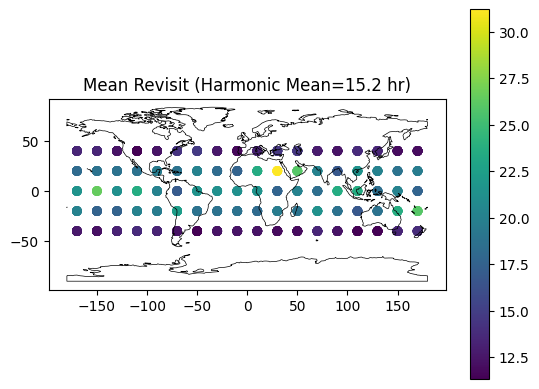

In [15]:
import matplotlib.pyplot as plt

# load shapefile
world = gpd.read_file(
    "https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip"
)

# example composite plot using GeoDataFrames
fig, ax = plt.subplots()
ax.set_title(f"Number Samples (Coverage={response2.coverage_fraction:.1%})")
data2.plot(ax=ax, column="number_samples", legend=True)
world.boundary.plot(ax=ax, lw=0.5, color="k")
ax.set_aspect("equal")
plt.show()

# example composite plot using GeoDataFrames
fig, ax = plt.subplots()
ax.set_title(
    f"Mean Revisit (Harmonic Mean={response2.harmonic_mean_revisit/timedelta(hours=1):.1f} hr)"
)
data2["mean_revisit_hr"] = data2.apply(
    lambda r: r["mean_revisit"] / timedelta(hours=1), axis=1
)
data2.plot(ax=ax, column="mean_revisit_hr", legend=True)
world.boundary.plot(ax=ax, lw=0.5, color="k")
ax.set_aspect("equal")
plt.show()